In [1]:
#!/usr/bin/env python
"""
Definition of test problems
--------------------------------------------------------------------------
Created December 10, 2022 for TRIPs-Py library
"""
__author__ = "Mirjeta Pasha and Connor Sanderford"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = "Mirjeta Pasha"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com"
import os,sys
sys.path.insert(0,'/Users/mirjetapasha/Documents/Research_Projects/TRIPSpy/TRIPSpy')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
from trips.operators import *
##Specify the font
##Latex needs to be installed! If not installed, please comment the following 5 lines
# parameters = {'xtick.labelsize': 12, 'ytick.labelsize': 12,
#           'axes.titlesize': 18, 'axes.labelsize': 18, 'figure.titlesize': 14, 'legend.fontsize': 13}
# plt.rcParams.update(parameters)
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
import phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
from trips.testProblems import *
from trips.operators import *
from trips.solvers.gks import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *

##### Illustrate the ill-posedness of some inverse problem examples and show the need for regularization
<p>In this example we illustrate the following:

Step 1: Generate a small deblurring example


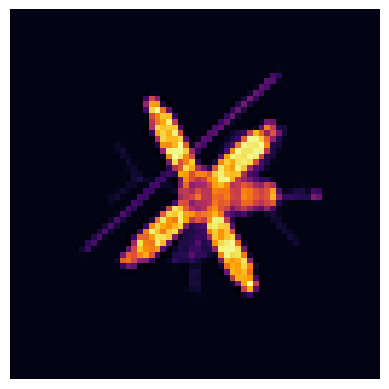

<Figure size 640x480 with 0 Axes>

In [2]:
# Deblurring example test problem
Deblur = Deblurring()
# In the class Deblurring we have can define the type of problem to be used.
generate_matrix = True #Defines a blurring operator where the forward operator matrix is formed explicitly
imagesize_x = 64 # Define the first dimension of the image
imagesize_y = 64 # Defines the second dimension of the image
spread = 1.5 # The PSF parameter
choose_image = 'satellite64' #The choice of the image
if generate_matrix == True:
        # spread = [2,2]
        size = imagesize_x
        shape = (size, size)
        spreadnew = (spread, spread)
        A = Deblur.forward_Op_matrix(spreadnew, shape, imagesize_x, imagesize_y)
x_true = Deblur.generate_true(choose_image)
b_true = Deblur.generate_data(x_true, generate_matrix)
(b, delta) = Deblur.add_noise(b_true, 'Gaussian', noise_level = 0.01)
Deblur.plot_rec(x_true.reshape((shape), order = 'F'), save_imgs = True, save_path='./saveImagesDeblurring'+'rec'+choose_image)

In [3]:
from trips.solvers.GMRES import *
xx = GMRES(A, b, 10, dp_stop = 0)

10


generating basis...:   0%|          | 0/10 [00:00<?, ?it/s]

generating basis...: 100%|██████████| 10/10 [00:00<00:00, 44.17it/s]


Step 2: Solve the least-squares problem
$\|\mathbf A{\mathbf x} - {\mathbf b}\|^2_2$

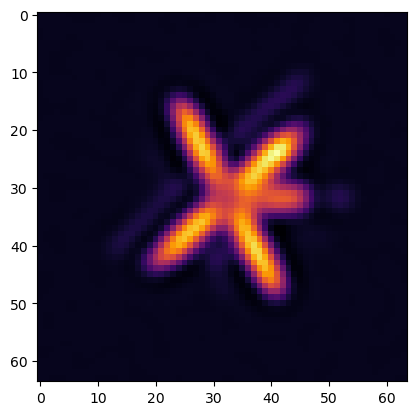

In [4]:
alpha = 0.1
b_vec = b.reshape((-1,1))
L = np.identity(A.shape[1], dtype='float32')
xTik = np.linalg.solve(A.T@A + alpha*L.T@L, A.T@b_vec)
plt.imshow((xTik.reshape((imagesize_x, imagesize_x))))

In [5]:
xx = Tikhonov(A, b_vec, L, x_true, regparam = 'gcv')

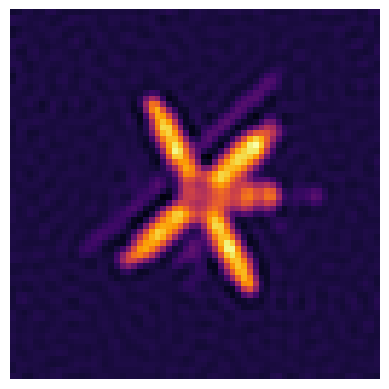

<Figure size 640x480 with 0 Axes>

In [6]:
Deblur.plot_rec(xx.reshape((64,64)), save_imgs = True, save_path='./saveImagesDeblurring')

Analyze the singular value expansion of the forward operator

generating basis...: 100%|██████████| 50/50 [00:00<00:00, 60.23it/s] 


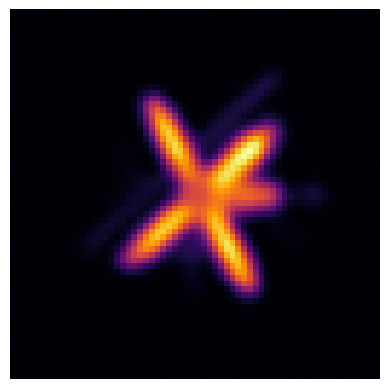

0.9132208697123169

<Figure size 640x480 with 0 Axes>

In [7]:
##Unregularized Arnoldi
##Arnoldi here
projection_dim = 50
(V,H) = arnoldi(A, projection_dim, b_vec)
UU = V[:, 0:-1]
HH = H[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_Arnoldi_tikh = UU.dot(y_tikh)
Deblur.plot_rec(x_Arnoldi_tikh.reshape(imagesize_x, imagesize_y))
np.linalg.norm(x_Arnoldi_tikh-x_true.reshape((-1,1)))/np.linalg.norm(x_true.reshape((-1,1)))


generating basis...: 100%|██████████| 100/100 [00:01<00:00, 83.10it/s]


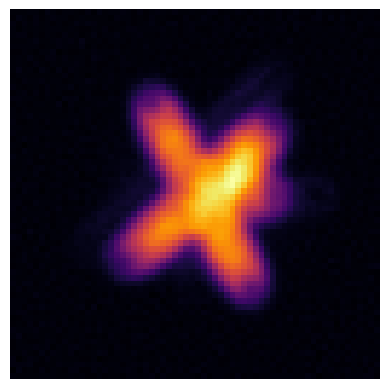

0.8529910955618545

<Figure size 640x480 with 0 Axes>

In [8]:
## Regularized Arnoldi here
projection_dim = 100
(V,H) = arnoldi(A, projection_dim, b_vec)
UU = V[:, 0:-1]
HH = H[0:-1, :]
reg_param = 0.00001
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH + reg_param*np.ones((HH.T.shape[0],HH.T.shape[0])), HH.T@bhat)
x_Arnoldi_tikh = UU.dot(y_tikh)
Deblur.plot_rec(x_Arnoldi_tikh.reshape(imagesize_x, imagesize_y))
np.linalg.norm(x_Arnoldi_tikh-x_true.reshape((-1,1)))/np.linalg.norm(x_true.reshape((-1,1)))


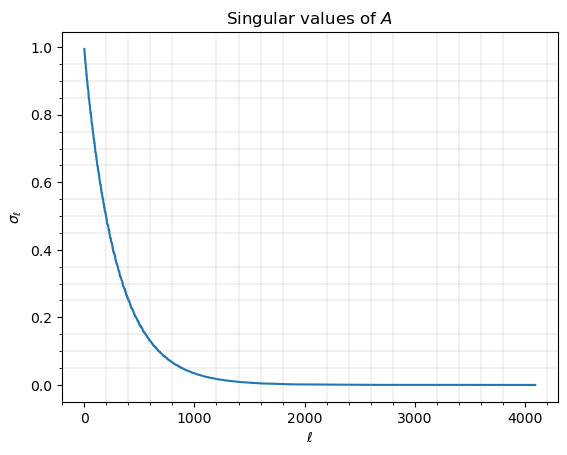

In [9]:
U, S, VT = np.linalg.svd(A)
V = VT.T
plt.plot(S)
plt.title('Singular values of $A$')
plt.xlabel('$\ell$')
plt.ylabel('$\sigma_{\ell}$')
plt.minorticks_on()
# plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
plt.savefig('singular_values.png', bbox_inches='tight')
plt.show()

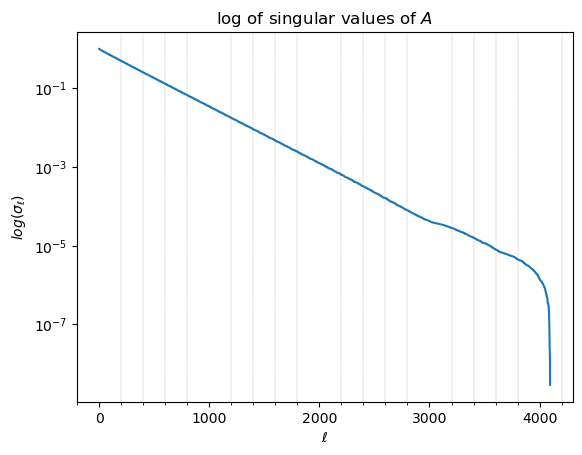

In [25]:
U, S, VT = np.linalg.svd(A)
V = VT.T
plt.semilogy(S)
plt.title('log of singular values of $A$')
plt.xlabel('$\ell$')
plt.ylabel('$log(\sigma_{\ell})$')
plt.minorticks_on()
# plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
plt.savefig('logsingular_values.png', bbox_inches='tight')
plt.show()

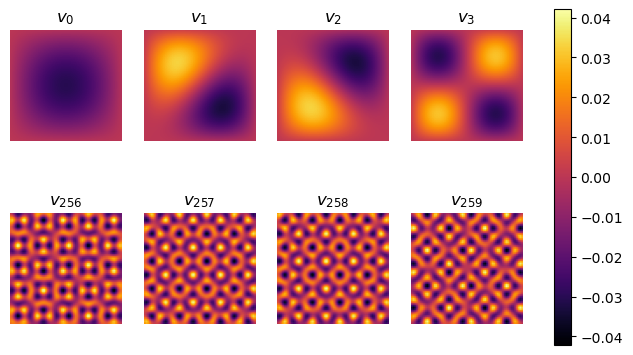

In [43]:
## Plotting the singular vectors here
n = 2
m = 4
fig, axes = plt.subplots(n, m)
v_i = [V[:, k] for k in range(m)]
v_i += [V[:, k] for k in range(128, 128+m)]
right_singular = np.array(v_i)
immax = np.max(right_singular)
immin = np.min(right_singular)
k = 0
for i in range(n):
    for j in range(m):
        image = axes[i][j].imshow(-V[:, k].reshape(size, size), vmin=immin, vmax=immax, cmap='inferno')
        axes[i][j].axis('off')
        axes[i][j].set_title(r'$v_{' + str(k) + r'}$')
        k += 1
    k = 256
plt.subplots_adjust(bottom=0, top=0.7, left = 0, right=1)
fig.colorbar(image, ax=axes.ravel().tolist())
plt.savefig('v_vectors.png', bbox_inches='tight')
plt.show()

## Compute the truncated SVD solution

In [12]:
x_tsvd = TruncatedSVD_sol(A, 20, b_vec)

In [13]:
error = np.linalg.norm(x_tsvd.reshape((-1,1)) - x_true.reshape((-1,1)))/np.linalg.norm(x_true.reshape((-1,1)))
error

0.790406210921318

(-0.5, 63.5, 63.5, -0.5)

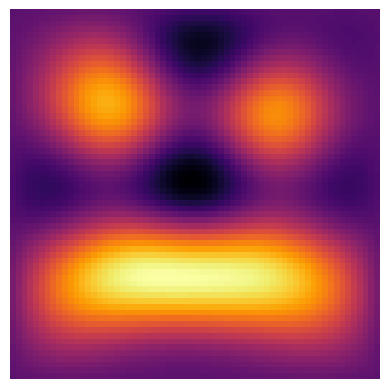

In [14]:
plt.imshow(x_tsvd.reshape((64,64)))
plt.axis('off')

In [ ]:
b = b_vec
lamb = 1/16
minerror = 10000
lambdas = []
xnorms = []
residuals = []
while lamb > 1e-7:
    F = np.array([s/(s**2 + lamb**2) for s in S])
    x_reg = V @ np.diag(F) @ U.T @ b
    lambdas.append(lamb)
    xnorms.append(np.linalg.norm(x_reg))
    residuals.append(np.linalg.norm(A @ x_reg - b))
    error = np.linalg.norm(x_reg - x_true)/np.linalg.norm(x_true)
    if error < minerror:
        minerror = error
        minlamb = lamb
        minx = x_reg
        minxnorm = xnorms[-1]
        minresidual = residuals[-1]
    lamb /= 2
l_curve = list(zip(lambdas, residuals, xnorms))
print('Minima:')
print('Lambda   = ', minlamb)
print('residual = ', minresidual)
print('error   = ', minerror)
print('x_norm   = ', minxnorm)

Minima:
Lambda   =  0.0625
residual =  0.34541083070774053
error   =  74.92000436524067
x_norm   =  33.64708752308493


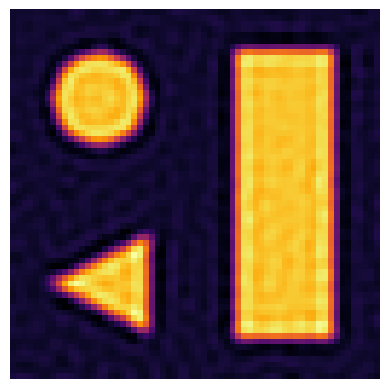

<Figure size 640x480 with 0 Axes>

In [ ]:
Deblur.plot_rec(minx.reshape(shape, order = 'F'), save_imgs = True, save_path='./saveImagesDeblurring'+'rec'+choose_image)


Step 3: Solve the regularized problem

$\|\mathbf A{\mathbf x} - {\mathbf b}\|_2 + \lambda \|\mathbf L\mathbf x\|_q$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. The value of $q$ can be choosen from (0, 2].

In [22]:
def FirstDerOperator_1D(n):
    d = np.ones(n-1)
    D = np.diag(d,-1)
    L = np.identity(n)-D
    return L
# construct regularization matrix of first derivative operator 2D
def FirstDerOperator_2D(n):
    L1 = FirstDerOperator_1D(n)
    KP1 = np.kron(np.identity(n), L1)
    KP2 = np.kron(L1, np.identity(n))
    L = np.vstack((KP1, KP2))
    return L
# L = spatial_derivative_operator(imagesize_x, imagesize_y, 1)
L = FirstDerOperator_2D(shape[0])


Step 3: Solve the regularized problem

$\|\mathbf A{\mathbf x} - {\mathbf b}\|^2_2 + \lambda \|\mathbf L\mathbf x\|_2^2$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. 

In [26]:
xx = Tikhonov(A, b_vec, L, x_true, 'gcv')

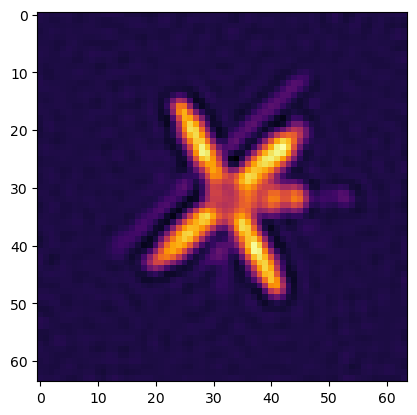

In [27]:
plt.imshow(xx.reshape(64,64))


Step 3: Solve the regularized problem

$\|\mathbf A{\mathbf x} - {\mathbf b}\|_2 + \lambda \|\mathbf L\mathbf x\|_q$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. The value of $q$ can be choosen from (0, 2]. We let $p=1$ here.

In [32]:
from trips.solvers.gks import *
# MMGKS(A, b, L, pnorm=1, qnorm=1, projection_dim=3, iter=50, regparam='gcv', x_true=None, **kwargs):
xhat = MMGKS(A, b_vec, L, pnorm = 2, qnorm = 1, projection_dim= 2, iter = 20, regparam = 'dp', delta = delta)
    #    GKS(A, b, L, projection_dim=3, iter=50, selection_method = 'gcv', **kwargs):

running MMGKS...:   0%|          | 0/20 [00:00<?, ?it/s]/Users/mirjetapasha/Documents/Research_Projects/TripsPY_May24/multiparameter_package/multiparameter_package/trips/parameter_selection/discrepancy_principle.py:50: RuntimeWarning: divide by zero encountered in true_divide
  beta_new = beta - f/f_prime
/Users/mirjetapasha/Documents/Research_Projects/TripsPY_May24/multiparameter_package/multiparameter_package/trips/parameter_selection/discrepancy_principle.py:53: RuntimeWarning: invalid value encountered in subtract
  if abs(beta_new - beta) < 10**(-7)* beta:
running MMGKS...:  10%|█         | 2/20 [00:00<00:09,  1.98it/s]/Users/mirjetapasha/Documents/Research_Projects/TripsPY_May24/multiparameter_package/multiparameter_package/trips/parameter_selection/discrepancy_principle.py:50: RuntimeWarning: overflow encountered in true_divide
  beta_new = beta - f/f_prime
running MMGKS...: 100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


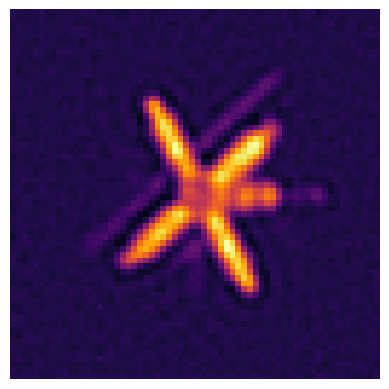

<Figure size 640x480 with 0 Axes>

In [33]:
Deblur.plot_rec(xhat[0].reshape(shape))